In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import random
from tensorflow.keras.utils import image_dataset_from_directory,to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.metrics import Recall,Precision,Accuracy

Visualizing Dataset

In [2]:
folder = r'D:\BrainTumorDetector\dataset'

In [3]:
data = image_dataset_from_directory(folder,label_mode='categorical')

Found 5712 files belonging to 4 classes.


In [4]:
data_iter = data.as_numpy_iterator()

In [5]:
batch = data_iter.next()

d:\Python\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


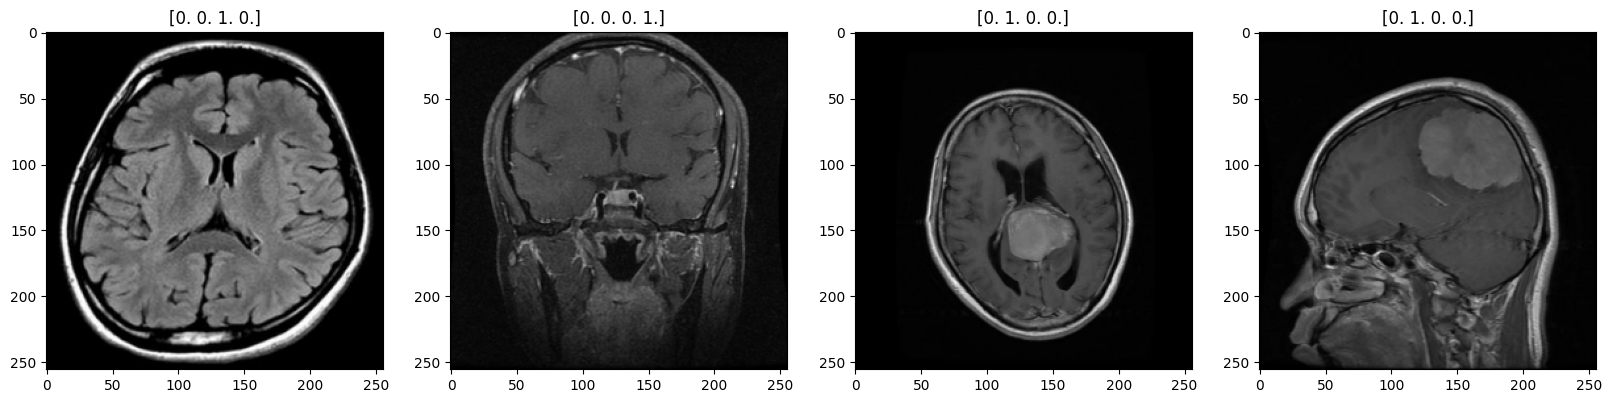

In [6]:
fig,axs = plt.subplots(ncols=4, figsize=(20,20))
for id,img in enumerate(batch[0][:4]):
    axs[id].imshow(img.astype(int))
    axs[id].title.set_text(batch[1][id])

Splitting datasets

In [7]:
print(len(data))

179


In [8]:
print(batch[0].shape)

(32, 256, 256, 3)


In [9]:
train_size = int(len(data)*0.75)
val_size = int(len(data)*0.10)+2
test_size = int(len(data)*0.15)
print(train_size,':',val_size,':',test_size)

134 : 19 : 26


In [10]:
train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Model Architecture

In [11]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=4,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

Model training and evaluation

In [12]:
tf_callback = r'D:\Models\Braintumor\callbacks'
callbacks = tf.keras.callbacks.TensorBoard(log_dir=tf_callback)
results = model.fit(train,epochs=10,validation_data=validation,callbacks=[callbacks])

Epoch 1/10
134/134 [==============================] - 816s 6s/step - loss: 14.7083 - accuracy: 0.7614 - val_loss: 0.3042 - val_accuracy: 0.8947
Epoch 2/10
134/134 [==============================] - 762s 6s/step - loss: 0.2846 - accuracy: 0.9007 - val_loss: 0.3301 - val_accuracy: 0.8849
Epoch 3/10
134/134 [==============================] - 774s 6s/step - loss: 0.1722 - accuracy: 0.9426 - val_loss: 0.2031 - val_accuracy: 0.9375
Epoch 4/10
134/134 [==============================] - 863s 6s/step - loss: 0.0819 - accuracy: 0.9753 - val_loss: 0.2281 - val_accuracy: 0.9474
Epoch 5/10
134/134 [==============================] - 761s 6s/step - loss: 0.1044 - accuracy: 0.9653 - val_loss: 0.2749 - val_accuracy: 0.8980
Epoch 6/10
134/134 [==============================] - 745s 6s/step - loss: 0.0746 - accuracy: 0.9753 - val_loss: 0.3381 - val_accuracy: 0.9326
Epoch 7/10
134/134 [==============================] - 903s 7s/step - loss: 0.0473 - accuracy: 0.9865 - val_loss: 0.3004 - val_accuracy: 0.937

Testing model

In [13]:
precision = Precision()
recall = Recall()
accuracy = Accuracy()

In [16]:
for test_batch in test:
    X,y = test_batch
    pred = model.predict(X)
    precision.update_state(y,pred)
    recall.update_state(y,pred)
    accuracy.update_state(y,pred)
    
print('precision:{}\nrecall:{}\naccuracy:{}'.format(precision.result(),recall.result(),accuracy.result()))

1/1 [==============================] - 1s 1s/step
precision:0.9259493947029114
recall:0.9236111044883728
accuracy:0.14094065129756927


In [17]:
f1_score = (2*precision.result()*recall.result())/(precision.result()+recall.result())
print('F1-score : ',f1_score)

F1-score :  tf.Tensor(0.92477876, shape=(), dtype=float32)


Evaluating Model

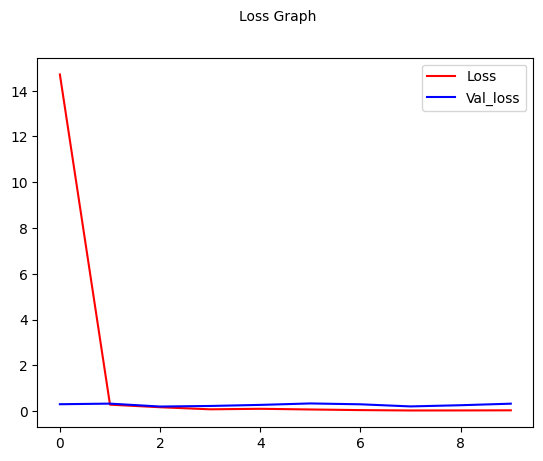

In [22]:
fig = plt.figure()
plt.plot(results.history['loss'],color='red',label='Loss')
plt.plot(results.history['val_loss'],color='blue',label='Val_loss')
fig.suptitle('Loss Graph',fontsize=10)
plt.legend()
plt.show()

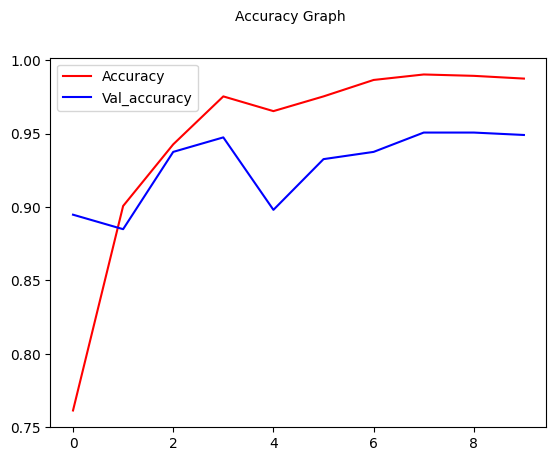

In [28]:
fig = plt.figure()
plt.plot(results.history['accuracy'],color='red',label='Accuracy')
plt.plot(results.history['val_accuracy'],color='blue',label='Val_accuracy')
fig.suptitle('Accuracy Graph',fontsize=10)
plt.legend()
plt.show()

Save model

In [ ]:
# save_path = r'D:\Models\Braintumor'
# model.save(os.path.join(save_path,'ICmodel_1.h5'))

In [26]:
test_fol = r'D:\BrainTumorDetector\Testing'
test_dirs = ['glioma','meningioma','notumor','pituitary']
directory = random.choice(test_dirs)
allimgs = os.listdir(os.path.join(test_fol,directory))
test_img = random.choice(allimgs)
test_img = os.path.join(test_fol,directory,test_img)
print(test_img)
timg = cv2.imread(test_img)
timg = tf.image.resize(timg,(256,256))
print(timg.shape)

D:\BrainTumorDetector\Testing\meningioma\Te-me_0175.jpg
(256, 256, 3)


In [27]:
predict = model.predict(np.expand_dims(timg,axis=0))
print(np.argmax(predict))

1/1 [==============================] - 0s 180ms/step
1
